<a href="https://colab.research.google.com/github/leobertolazzi/aes-bert/blob/main/aes_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Essay Scoring with RoBERTa embeddings

## Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import cohen_kappa_score as kappa
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import RobertaTokenizer, RobertaModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

## Device

In [3]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset

In [6]:
# Original kaggle training set
kaggle_dataset  = pd.read_csv('data/training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")

# Smaller training set used for this project
dataset = pd.DataFrame(
  {
    'essay_id' : kaggle_dataset['essay_id'],
    'essay_set' : kaggle_dataset['essay_set'],
    'essay' : kaggle_dataset['essay'],
    'rater1' : kaggle_dataset['rater1_domain1'],
    'rater2' : kaggle_dataset['rater2_domain1'],
    'score' : kaggle_dataset['domain1_score']
  }
)

In [ ]:
kaggle_dataset.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dataset.head()

,essay_id,essay_set,essay,rater1,rater2,score
0,1,1,"Dear local newspaper, I think effects computer...",4,4,8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,8


In [ ]:
dataset.shape

(12976, 6)

## Average Essay Length

In [4]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [7]:
length_dict = {}

for essay_set in range(1,9):
    length_dict[essay_set] = [len(tokenizer.tokenize(essay)) for essay in dataset[dataset['essay_set'] == essay_set]['essay']]

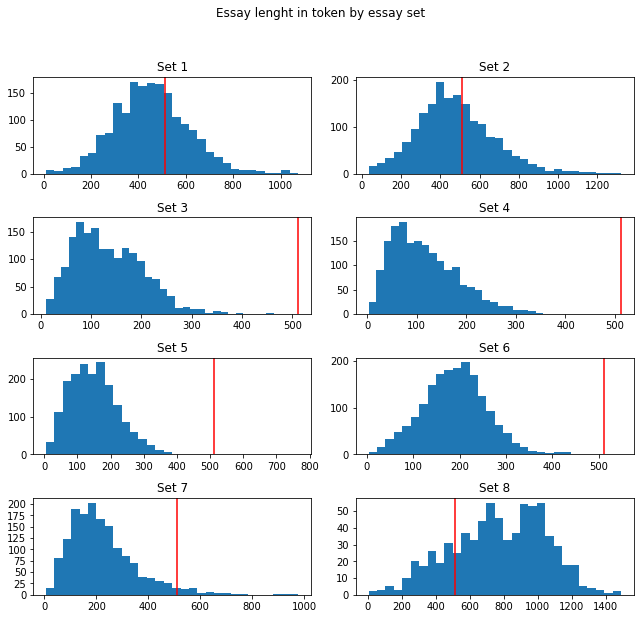

In [8]:
set_number = 0
fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
for i in range(4):
  for j in range(2):
      set_number += 1
      ax[i,j].hist(length_dict[set_number], bins=30)
      ax[i,j].axvline(512, c="red")
      ax[i,j].set_title('Set %i' % set_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Essay lenght in token by essay set')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

As it can be seen, most of the essays are less than 512 tokens.

However, for set 1 and 2 more or less half of the essays are more than 512 tokens; for set 8 most essays are more the 512 tokens.

For set 1, 2 and 8 part of the information will be lost due to the limitation of RoBERTa to encode a sequence of 512 tokens.


## Add Scaled Scores to Dataset

In [ ]:
def get_scaled_dataset(dataset):

  scaler = StandardScaler()
  scaled = []
  for essay_set in range(1,9):
    score = dataset[dataset['essay_set'] == essay_set]['score'].to_frame()
    s = (scaler.fit_transform(score).reshape(-1))
    scaled = np.append(scaled, s)

  scaled_dataset = dataset.copy()
  scaled_dataset['scaled_score'] = scaled

  return scaled_dataset

## Essays Encodings

### Id to Embedding dictionary

`get_id2emb` creates a dictionary which maps essay ids to the embeddings encoded by the two models

In [ ]:
def get_id2emb(ids):

  id2emb = {}
  for n,id in enumerate(ids.to_list()):
    id2emb[id] = n

  print('Essay ids to emebeddings dictionary created.')
  
  return id2emb

In [ ]:
id2emb = get_id2emb(dataset['essay_id'])

Essay ids to emebeddings dictionary created.


### RoBERTa Encoding

Essay are encoded following these steps:
1. the first 512 tokens of an essay are encoded in 768-d RoBERTa embeddings;
2. the embedding of an essay is the average embedding of all tokens embeddings

In [5]:
roberta = RobertaModel.from_pretrained("roberta-base").to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def mean_encoding(essay_list, model, tokenizer):

  print('Encoding essay embeddings:')

  embeddings = []
  for essay in tqdm(essay_list):
    encoded_input = tokenizer(essay, padding=True, truncation=True, return_tensors='pt').to(device)
    with torch.no_grad():
      model_output = model(**encoded_input)
    tokens_embeddings = np.matrix(model_output[0].squeeze().cpu())
    embeddings.append(np.squeeze(np.asarray(tokens_embeddings.mean(0))))

  return np.matrix(embeddings)

In [ ]:
essay_embeddings = mean_encoding(dataset['essay'], roberta, tokenizer)

Encoding essay embeddings:


  0%|          | 0/12976 [00:00<?, ?it/s]

## Dataloaders

In [ ]:
def get_loader(df, id2emb, essay_embeddings, shuffle=True):

  # get embeddings from essay_id using id2emb dict
  embeddings = np.array([essay_embeddings[id2emb[id]] for id in df['essay_id']])

  # dataset and dataloader
  data = TensorDataset(torch.from_numpy(embeddings).float(), torch.from_numpy(np.array(df['scaled_score'])).float())
  loader = DataLoader(data, batch_size=128, shuffle=shuffle, num_workers=2)

  return loader

## MLP Regressor

In [ ]:
class MLP(torch.nn.Module):
  
  def __init__(self, input_size):
    super(MLP, self).__init__()
    
    self.layers = torch.nn.Sequential(
      torch.nn.Linear(input_size, 256),
      torch.nn.ReLU(),
      torch.nn.Dropout(0.3),
      torch.nn.Linear(256, 96),
      torch.nn.ReLU(),
      torch.nn.Dropout(0.3),
      torch.nn.Linear(96, 1)
    ) 

  def forward(self, x):
    return self.layers(x)

In [ ]:
def training_step(model, cost_function, optimizer, train_loader):

  samples = 0.
  cumulative_loss = 0.

  model.train() 

  for step, (inputs, targets) in enumerate(train_loader):

    inputs = inputs.squeeze(dim=1).to(device)
    targets = targets.reshape(targets.shape[0],1).to(device)

    outputs = model(inputs)

    loss = cost_function(outputs, targets)

    loss.backward()  
  
    optimizer.step()  
 
    optimizer.zero_grad()

    samples += inputs.shape[0]
    cumulative_loss += loss.item()

  return cumulative_loss/samples


def test_step(model, cost_function, optimizer, test_loader):

  samples = 0.
  cumulative_loss = 0.
  preds = []

  model.eval() 

  with torch.no_grad():
    for step, (inputs, targets) in enumerate(test_loader):

      inputs = inputs.squeeze(dim=1).to(device)
      targets = targets.reshape(targets.shape[0],1).to(device)

      outputs = model(inputs)

      loss = cost_function(outputs, targets)

      samples += inputs.shape[0]
      cumulative_loss += loss.item()
      for out in outputs:
        preds.append(float(out))

  return cumulative_loss/samples, preds

## Training




In [ ]:
# hyper-parameters
input_size = 768
epochs = 20
lr = 3e-4

# cross-validation folds
kf = KFold(n_splits=5, random_state=2022, shuffle=True)

# dicts with train_df, test_df and predictions for each model
train_df_dict = {}
test_df_dict = {}
preds_dict = {}

# copy of dataset with scaled scores computed using the whole dataset
scaled_dataset = get_scaled_dataset(dataset)

for n, (train, test) in enumerate(kf.split(dataset)):
  
  # train, test splits 
  # scaled scores in train_df are computed only using training data
  train_df = dataset.iloc[train]
  train_df = get_scaled_dataset(train_df)

  test_df = scaled_dataset.iloc[test]

  # dataloaders
  train_loader = get_loader(train_df, id2emb, essay_embeddings, shuffle=True)
  test_loader = get_loader(test_df, id2emb, essay_embeddings, shuffle=False)

  # model
  print('------------------------------------------------------------------')
  print(f"\t\t\tTraining model: {n+1}")
  print('------------------------------------------------------------------')
  model = MLP(input_size).to(device)
  
  # loss and optimizer
  cost_function = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  # training
  train_loss, train_preds = test_step(model, cost_function, optimizer, train_loader)
  test_loss, test_preds = test_step(model, cost_function, optimizer, test_loader)
  print('Before training:\tLoss/train: {:.5f}\tLoss/test: {:.5f}'.format(train_loss, test_loss))

  for epoch in range(epochs):
    train_loss = training_step(model, cost_function, optimizer, train_loader)
    test_loss, test_preds = test_step(model, cost_function, optimizer, test_loader)
    print('Epoch: {:}\t\tLoss/train: {:.5f}\tLoss/test: {:.5f}'.format(epoch+1,train_loss, test_loss))

  train_loss, train_preds = test_step(model, cost_function, optimizer, train_loader)
  test_loss, test_preds = test_step(model, cost_function, optimizer, test_loader)
  print('After training:\t\tLoss/train: {:.5f}\tLoss/test: {:.5f}'.format(train_loss, test_loss))

  # store test_df and predictions
  train_df_dict[f"model_{n+1}"] = train_df
  test_df_dict[f"model_{n+1}"] = test_df
  preds_dict[f"model_{n+1}"] = test_preds

------------------------------------------------------------------
			Training model: 1
------------------------------------------------------------------
Before training:	Loss/train: 0.00795	Loss/test: 0.00850
Epoch: 1		Loss/train: 0.00576	Loss/test: 0.00455
Epoch: 2		Loss/train: 0.00398	Loss/test: 0.00401
Epoch: 3		Loss/train: 0.00363	Loss/test: 0.00371
Epoch: 4		Loss/train: 0.00339	Loss/test: 0.00349
Epoch: 5		Loss/train: 0.00327	Loss/test: 0.00337
Epoch: 6		Loss/train: 0.00312	Loss/test: 0.00328
Epoch: 7		Loss/train: 0.00302	Loss/test: 0.00325
Epoch: 8		Loss/train: 0.00295	Loss/test: 0.00314
Epoch: 9		Loss/train: 0.00292	Loss/test: 0.00311
Epoch: 10		Loss/train: 0.00287	Loss/test: 0.00309
Epoch: 11		Loss/train: 0.00285	Loss/test: 0.00301
Epoch: 12		Loss/train: 0.00275	Loss/test: 0.00298
Epoch: 13		Loss/train: 0.00275	Loss/test: 0.00303
Epoch: 14		Loss/train: 0.00270	Loss/test: 0.00297
Epoch: 15		Loss/train: 0.00269	Loss/test: 0.00298
Epoch: 16		Loss/train: 0.00265	Loss/test: 0.0029

## Overall Results

In [ ]:
def get_results_df(train_df, test_df, model_preds):

  # create new results df with model scaled preds
  preds_df = pd.DataFrame(model_preds)
  results_df = test_df.reset_index(drop=True)\
              .join(preds_df)\
              .rename(columns={0:'scaled_pred'})\
              .sort_values(by='essay_set')\
              .reset_index(drop=True)

  # move score to last colum
  s_df = results_df.pop('score')
  results_df['score'] = s_df

  # scale back to original range by essay set
  preds = pd.Series(dtype='float64')
  for essay_set in range(1,9):
    scaler = StandardScaler()  
    score_df = train_df[train_df['essay_set'] == essay_set]['score'].to_frame()
    scaler.fit(score_df)
    scaled_preds = results_df.loc[results_df['essay_set'] == essay_set, 'scaled_pred'].to_frame()
    preds_rescaled = scaler.inverse_transform(scaled_preds).round(0).astype('int')
    preds = preds.append(pd.Series(np.squeeze(np.asarray(preds_rescaled))), ignore_index=True)

  # append to results df
  results_df['pred'] = preds

  return results_df

In [ ]:
# list of mqw_kappa for each model
mqwk_list = []

for model_id in test_df_dict:

  results_df = get_results_df(train_df_dict[model_id], test_df_dict[model_id], preds_dict[model_id])

  kappas_by_set = []
  for essay_set in range(1,9):
    kappas_by_set.append(kappa(results_df.loc[results_df['essay_set'] == essay_set, 'score'],
                            results_df.loc[results_df['essay_set'] == essay_set, 'pred'],
                            weights='quadratic'))
    
  mqwk_list.append(np.mean(kappas_by_set))
print('----------------------------------------------')
print('mean QWK after 5-fold cross-validation:\t{:.4f}'.format(np.mean(mqwk_list)))
print('Max mean QWK:\t\t\t\t{:.4f}'.format(max(mqwk_list)))
print('Min mean QWK:\t\t\t\t{:.4f}'.format(min(mqwk_list)))

raters_kappas = []
for essay_set in range(1,9):
  raters_kappas.append(kappa(dataset.loc[dataset['essay_set'] == essay_set, 'rater1'], 
                      dataset.loc[dataset['essay_set'] == essay_set, 'rater2'],
                      weights='quadratic'))
  
mqwk_raters = np.mean(raters_kappas)
print('----------------------------------------------')
print('mean QWK for two human raters:\t\t{:.4f}'.format(mqwk_raters))
print('----------------------------------------------')

----------------------------------------------
mean QWK after 5-fold cross-validation:	0.7531
Max mean QWK:				0.7684
Min mean QWK:				0.7365
----------------------------------------------
mean QWK for two human raters:		0.7537
----------------------------------------------


## Results by Model

In [ ]:
def show_results(id):
  
  model_id = f"model_{id}"
  results_df = get_results_df(train_df_dict[model_id], test_df_dict[model_id], preds_dict[model_id])

  kappas_by_set = []
  for essay_set in range(1,9):
    kappas_by_set.append(kappa(results_df.loc[results_df['essay_set'] == essay_set, 'score'],
                            results_df.loc[results_df['essay_set'] == essay_set, 'pred'],
                            weights='quadratic'))
  print('--------------------------------------')
  print(f"\tResults for model: {id}")
  print('--------------------------------------')
  for essay_set in range(8):
    print('Kappa for essay set {:}:\t\t{:.4f}'.format(essay_set+1, kappas_by_set[essay_set]))
  print('mean QWK:\t\t\t{:.4f}'.format(np.mean(kappas_by_set)))
  
  return results_df

def plot_results(results_df, id):
  set_number = 0
  fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
  for i in range(4):
    for j in range(2):
      set_number += 1
      results_df[results_df['essay_set'] == set_number]\
        [['score', 'pred']]\
        .plot.hist(histtype='step', bins=20, ax=ax[i, j], rot=0)
      ax[i,j].set_title('Set %i' % set_number)
  ax[3,0].locator_params(nbins=10)
  ax[3,1].locator_params(nbins=10)
  plt.suptitle(f'Histograms of scores for Model {id}')
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

### Model 1

In [ ]:
results_df = show_results(1)

--------------------------------------
	Results for model: 1
--------------------------------------
Kappa for essay set 1:		0.7805
Kappa for essay set 2:		0.6730
Kappa for essay set 3:		0.7184
Kappa for essay set 4:		0.8085
Kappa for essay set 5:		0.7985
Kappa for essay set 6:		0.8054
Kappa for essay set 7:		0.8210
Kappa for essay set 8:		0.7416
mean QWK:			0.7684


In [ ]:
results_df.head()

,essay_id,essay_set,essay,rater1,rater2,scaled_score,scaled_pred,score,pred
0,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,-0.993622,-0.573329,7,8
1,1267,1,In my opinion i think computers have a positiv...,4,4,-0.343483,0.082959,8,9
2,1263,1,"Dear @ORGANIZATION1, I think that more people ...",5,4,0.306655,-0.186906,9,8
3,1260,1,"Dear local newspaper, @CAPS1 name is @CAPS2 @C...",4,4,-0.343483,-0.311679,8,8
4,1259,1,"To whomever this @MONTH1 concern, @CAPS1 your ...",5,5,0.956794,0.856901,10,10


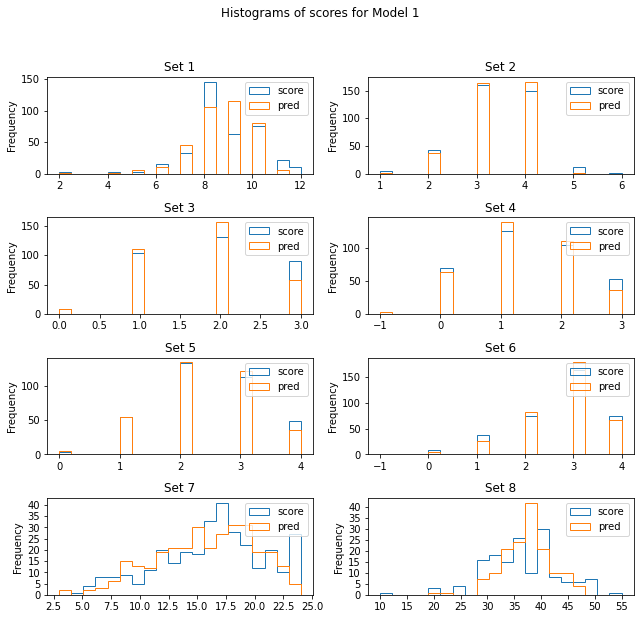

In [ ]:
plot_results(results_df, 1)

### Model 2

In [ ]:
results_df = show_results(2)

--------------------------------------
	Results for model: 2
--------------------------------------
Kappa for essay set 1:		0.8240
Kappa for essay set 2:		0.6667
Kappa for essay set 3:		0.7005
Kappa for essay set 4:		0.7856
Kappa for essay set 5:		0.8112
Kappa for essay set 6:		0.7759
Kappa for essay set 7:		0.8180
Kappa for essay set 8:		0.7591
mean QWK:			0.7676


In [ ]:
results_df.head()

,essay_id,essay_set,essay,rater1,rater2,scaled_score,scaled_pred,score,pred
0,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,-0.343483,0.518011,8,9
1,1162,1,"Dear Local @CAPS1 Newspaper, @CAPS2 I see why ...",4,4,-0.343483,0.365741,8,9
2,1154,1,"Dear Readers, I understand that some @MONTH1 t...",4,4,-0.343483,-0.853131,8,7
3,1148,1,"Dear @CAPS1, @CAPS2 you probably have seen the...",5,4,0.306655,0.237790,9,9
4,1147,1,"Dear @ORGANIZATION1 staff, Are computers helpf...",4,5,0.306655,0.921817,9,10


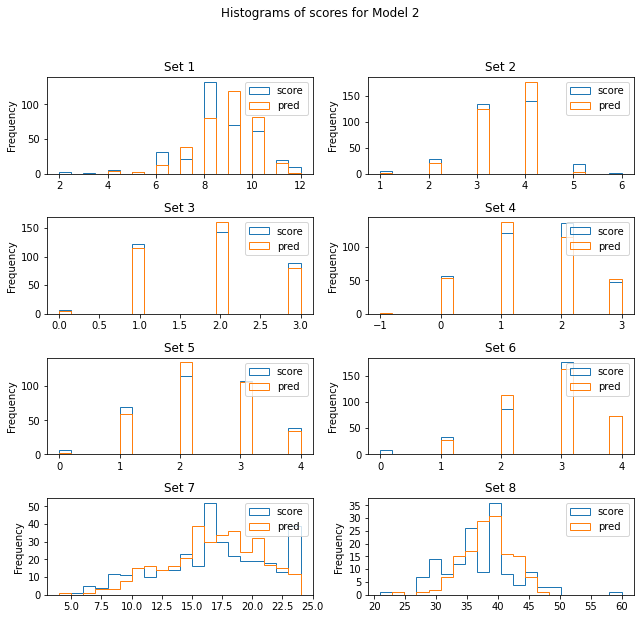

In [ ]:
plot_results(results_df, 2)

### Model 3

In [ ]:
results_df = show_results(3)

--------------------------------------
	Results for model: 3
--------------------------------------
Kappa for essay set 1:		0.8166
Kappa for essay set 2:		0.7061
Kappa for essay set 3:		0.6826
Kappa for essay set 4:		0.7814
Kappa for essay set 5:		0.7619
Kappa for essay set 6:		0.7860
Kappa for essay set 7:		0.7752
Kappa for essay set 8:		0.6692
mean QWK:			0.7474


In [ ]:
results_df.head()

,essay_id,essay_set,essay,rater1,rater2,scaled_score,scaled_pred,score,pred
0,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,0.306655,0.406942,9,9
1,1208,1,I disaree with computers are for you becau if ...,3,4,-0.993622,-2.115770,7,5
2,1204,1,To @CAPS1 @CAPS6 @MONTH1 concern: @CAPS2 I hav...,4,5,0.306655,1.032898,9,10
3,1200,1,"Dear local newspaper, @CAPS1 it has been broug...",5,4,0.306655,0.504556,9,9
4,1199,1,Computers are helpful in everyone's life. New ...,4,4,-0.343483,0.110378,8,9


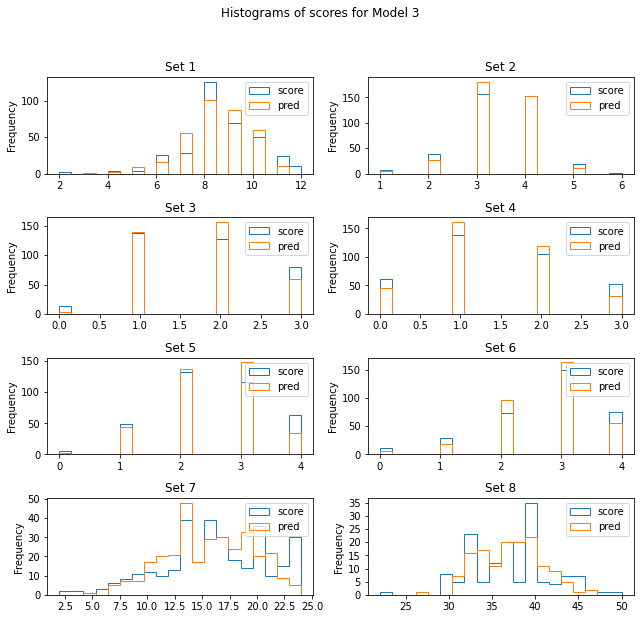

In [ ]:
plot_results(results_df, 3)

### Model 4

In [ ]:
results_df = show_results(4)

--------------------------------------
	Results for model: 4
--------------------------------------
Kappa for essay set 1:		0.7879
Kappa for essay set 2:		0.6446
Kappa for essay set 3:		0.6564
Kappa for essay set 4:		0.7904
Kappa for essay set 5:		0.7829
Kappa for essay set 6:		0.7618
Kappa for essay set 7:		0.8075
Kappa for essay set 8:		0.6602
mean QWK:			0.7365


In [ ]:
results_df.head()

,essay_id,essay_set,essay,rater1,rater2,scaled_score,scaled_pred,score,pred
0,1,1,"Dear local newspaper, I think effects computer...",4,4,-0.343483,-0.167375,8,8
1,1165,1,Dear @PERSON1 @CAPS1 I am writing this letter ...,4,4,-0.343483,-0.407781,8,8
2,1164,1,"Dear @CAPS1, I am aware of the current debate ...",4,5,0.306655,0.610875,9,9
3,1163,1,"Dear Newspaper, I strongly believe that the ef...",5,5,0.956794,1.203700,10,10
4,1158,1,Dear newspaper I think that there are many rea...,4,5,0.306655,0.318963,9,9


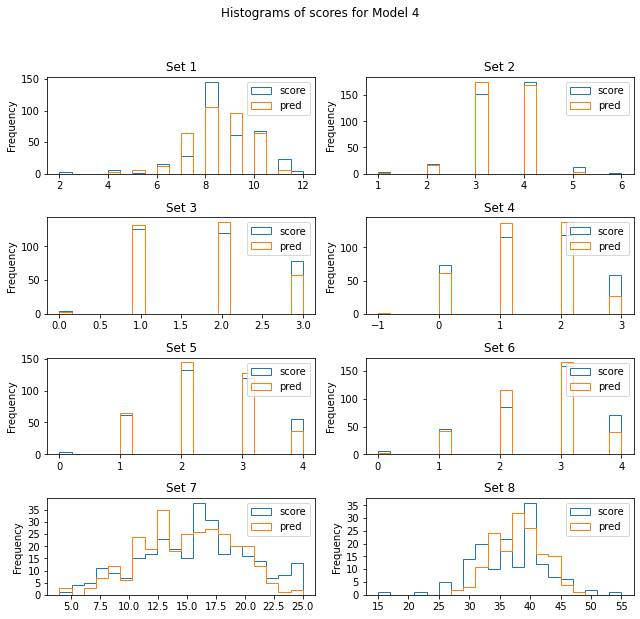

In [ ]:
plot_results(results_df, 4)

### Model 5

In [ ]:
results_df = show_results(5)

--------------------------------------
	Results for model: 5
--------------------------------------
Kappa for essay set 1:		0.8015
Kappa for essay set 2:		0.7253
Kappa for essay set 3:		0.6868
Kappa for essay set 4:		0.7489
Kappa for essay set 5:		0.7935
Kappa for essay set 6:		0.7778
Kappa for essay set 7:		0.8250
Kappa for essay set 8:		0.6064
mean QWK:			0.7456


In [ ]:
results_df.head()

,essay_id,essay_set,essay,rater1,rater2,scaled_score,scaled_pred,score,pred
0,6,1,"Dear @LOCATION1, I think that computers have a...",4,4,-0.343483,-0.814966,8,7
1,1268,1,People use computers everyday. There's so many...,4,4,-0.343483,-0.310474,8,8
2,1265,1,"Dear editors, I was planning on taking a trip ...",5,5,0.956794,0.370421,10,9
3,1261,1,Have you ever had someone move away and you wa...,4,5,0.306655,0.396185,9,9
4,1250,1,"Dear The @CAPS1 newspaper, @CAPS2 in front of ...",6,6,2.257071,1.301595,12,11


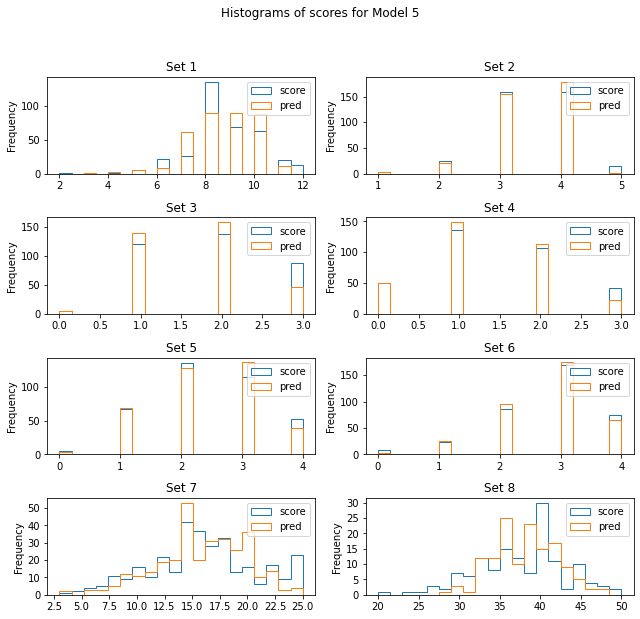

In [ ]:
plot_results(results_df, 5)